# 1. Libraries and Data
In this first section I import the data into the work space, and give it the necessary format to be used during the stochastic modeling process.

In [195]:
# Libraries
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import matplotlib as mlp
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import os
import datatable as dt
# import pmdarima as pm
%load_ext autoreload
%autoreload 2
import stochastic_modeling as stc

mlp.style.use('seaborn-notebook')
sns.set(font_scale=1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
full_rates = dt.fread('historico_tasas_python.csv').to_pandas().drop(
    columns = 'C0').set_index('Fecha', drop=True)
full_rates.tail()

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,DTF,IPC Anual,IPC Mensual,FED,UVR,...,IBC,USURA,TRM,DEV. TRM,LIBOR,SOFR,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-11-07,0.025,0.02451,0.02463,0.02875,0.03640,0.0238,0.0458,0.0001,0.0025,287.5667,...,0.1727,0.25905,3881.76,0.038406,0.002209,0.0005,24.2717,-0.008347,643.51,0.045542
2021-11-08,0.025,0.02450,0.02459,0.02799,0.03515,0.0244,0.0458,0.0001,0.0025,287.6019,...,0.1727,0.25905,3881.76,0.038406,0.002190,0.0005,24.2707,-0.008388,643.51,0.045542
2021-11-09,0.025,0.02448,0.02458,0.02778,0.03500,0.0244,0.0458,0.0001,0.0025,287.6371,...,0.1727,0.25905,3874.41,0.036440,0.002151,0.0005,24.2700,-0.008700,644.05,0.046419
2021-11-10,0.025,0.02457,0.02478,0.02800,0.03431,0.0244,0.0458,0.0001,0.0025,287.6722,...,0.1727,0.25905,3876.86,0.063275,0.002195,0.0005,24.2691,-0.008834,644.96,0.046317
2021-11-11,0.025,0.02457,0.02478,0.02800,0.03431,0.0244,0.0458,0.0001,0.0025,287.7074,...,0.1727,0.25905,3875.38,0.061603,0.002195,0.0005,24.2692,-0.008376,644.95,0.046012


In [87]:
monthly_rates = full_rates.groupby(pd.Grouper(freq='M')).last()

In [56]:
def jump_class(x):
    if x>=5: return 5
    elif x==0: return 1
    else: return x
tibr = full_rates.loc['2000-01-01':,'TIBR']
saltos_tibr = tibr.loc[tibr/tibr.shift(1)!=1].to_frame().reset_index()
dc = saltos_tibr['Fecha']
shift_dc = dc.shift(1)
saltos_tibr['delta_t'] = 12*(dc.dt.year-shift_dc.dt.year)+dc.dt.month-\
    shift_dc.dt.month
saltos_tibr = saltos_tibr.loc[saltos_tibr['Fecha']>='2011-01-01']
saltos_tibr['clase'] = np.vectorize(jump_class)(saltos_tibr['delta_t'].values)
lmbda = saltos_tibr['clase'].mean()

In [57]:
saltos_tibr.head(3)

,Fecha,TIBR,delta_t,clase
45,2011-02-28,0.0325,9.0,5
46,2011-03-22,0.0350,1.0,1
47,2011-05-02,0.0375,2.0,2


In [58]:
saltos_tibr['clase'].mean()

1.9056603773584906

<AxesSubplot:xlabel='Fecha'>

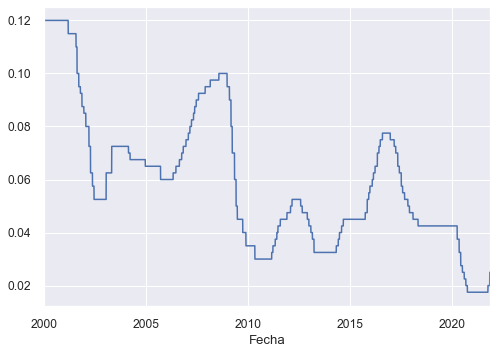

In [59]:
tibr.plot()

In [60]:
adfuller(transformed)

(-2.72915200848259,
 0.06912811597814457,
 9,
 43,
 {'1%': -3.5925042342183704,
  '5%': -2.931549768951162,
  '10%': -2.60406594375338},
 -95.09906664657046)

In [138]:
transformed = -np.log(0.15/saltos_tibr['TIBR']-1)
model = ARIMA(transformed.values, order=(4,0,4))
model_fit = model.fit()
model_fit.summary()

C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(4, 0, 4)   Log Likelihood                  65.936
Date:                Thu, 11 Nov 2021   AIC                           -111.872
Time:                        15:04:02   BIC                            -92.169
Sample:                             0   HQIC                          -104.295
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9311      0.303     -3.068      0.002      -1.526      -0.336
ar.L1         -0.1325      0.230     -0.576      0.565      -0.583       0.318
ar.L2          0.7114      0.329      2.162      0.031       0.066       1.356
ar.L3          0.2478      0.266      0.930      0.352      -0.274       0.770
ar.L4         -0.0662      0.334     -0.198      0.843      -0.722       0.589
ma.L1          2.0753      0.293      7.079      0.000       1.501       2.650
ma.L2          2.3209      0.440      5.278      0.000       1.459       3.183
ma.L3          1.7758      0.402      4.418      0.000       0.988       2.564
ma.L4          0.7851      0.223      3.515      0.000       0.347       1.223
sigma2         0.0042      0.001      3.601      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.97   Prob(JB):                         0.31
Heteroskedasticity (H):               1.56   Skew:                             0.26
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

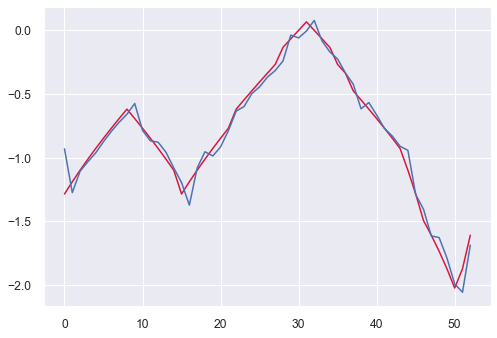

In [139]:
plt.plot(transformed.values, color='crimson')
plt.plot(model_fit.fittedvalues)

In [21]:
from sklearn.metrics import r2_score
r2_score(transformed.values, model_fit.fittedvalues)

0.9688527282287018

In [22]:
model_fit.resid.std()

0.08929020549007742

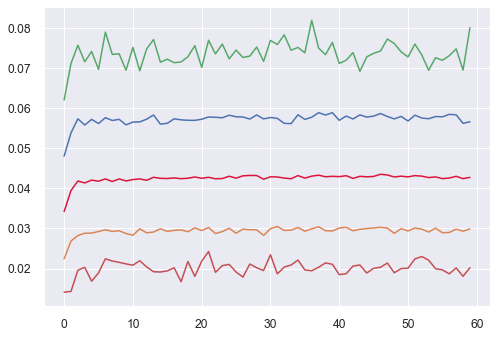

In [63]:
result = (model_fit.forecast(60)).reshape(60,1)+np.random.normal(
    scale = model_fit.resid.std()*np.sqrt(12),
    size = (60, 1000))
result = 0.15/(1+np.exp(-result))
mean = result.mean(axis=1)
mx = result.max(axis=1)
mn = result.min(axis=1)
ps = np.percentile(result, (5, 95), axis=1)
plt.plot(ps[1])
plt.plot(ps[0])
plt.plot(mean, color='crimson')
plt.plot(mx)
plt.plot(mn)

In [182]:
tibr_m

Fecha
2008-01-31    0.0950
2008-02-29    0.0975
2008-03-31    0.0975
2008-04-30    0.0975
2008-05-31    0.0975
               ...  
2021-06-30    0.0175
2021-07-31    0.0175
2021-08-31    0.0175
2021-09-30    0.0175
2021-10-31    0.0200
Freq: M, Name: TIBR, Length: 166, dtype: float64

In [205]:
tibr_m = monthly_rates.loc['2008-01-01':, 'TIBR']
poisson = stc.PoissonRateSeries(tibr_m['2008-01-01':], p=2)
poisson.get_full_df()

Lambda value = 2.07


C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2008-01-31,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,...,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950
2008-02-29,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-03-31,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-04-30,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-05-31,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-07-31,0.0350,0.0525,0.0500,0.0300,0.0450,0.0400,0.0350,0.0625,0.0500,0.0600,...,0.0375,0.0375,0.0400,0.0325,0.0350,0.0525,0.0525,0.0375,0.0275,0.0400
2026-08-31,0.0350,0.0525,0.0500,0.0375,0.0450,0.0400,0.0525,0.0625,0.0500,0.0600,...,0.0375,0.0375,0.0400,0.0325,0.0375,0.0625,0.0525,0.0375,0.0275,0.0400
2026-09-30,0.0350,0.0525,0.0450,0.0375,0.0450,0.0400,0.0625,0.0300,0.0500,0.0425,...,0.0450,0.0475,0.0400,0.0350,0.0375,0.0625,0.0525,0.0375,0.0275,0.0400
2026-10-31,0.0425,0.0375,0.0450,0.0375,0.0325,0.0400,0.0350,0.0375,0.0650,0.0425,...,0.0450,0.0600,0.0550,0.0425,0.0500,0.0625,0.0575,0.0400,0.0275,0.0450


(<Figure size 1080x504 with 1 Axes>, <AxesSubplot:>)

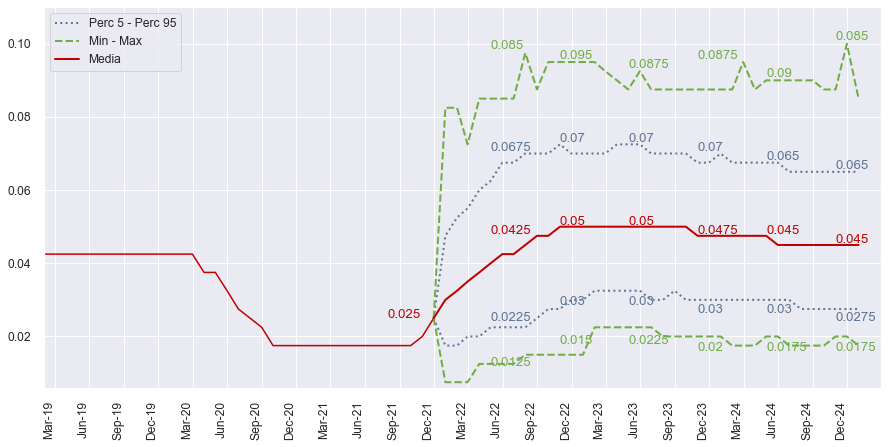

In [206]:
poisson.plot_full_series('2019-01-01','2024-12-31',dec=4, figsize=(15,7))

In [209]:
poisson.get_full_df()['2021'].mean(axis=1)

C:\Users\TELETR~1\AppData\Local\Temp/ipykernel_16880/1500984196.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  poisson.get_full_df()['2021'].mean(axis=1)


2021-01-31    0.017500
2021-02-28    0.017500
2021-03-31    0.017500
2021-04-30    0.017500
2021-05-31    0.017500
2021-06-30    0.017500
2021-07-31    0.017500
2021-08-31    0.017500
2021-09-30    0.017500
2021-10-31    0.020000
2021-11-30    0.025000
2021-11-30    0.025000
2021-12-31    0.030675
dtype: float64

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

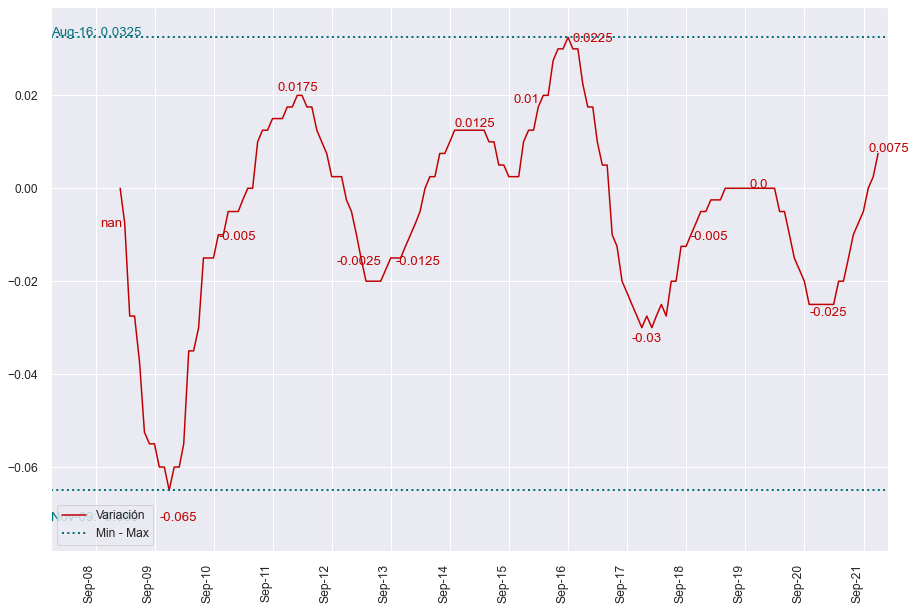

In [210]:
poisson.plot_historic_variation(ref=12, dec=4)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

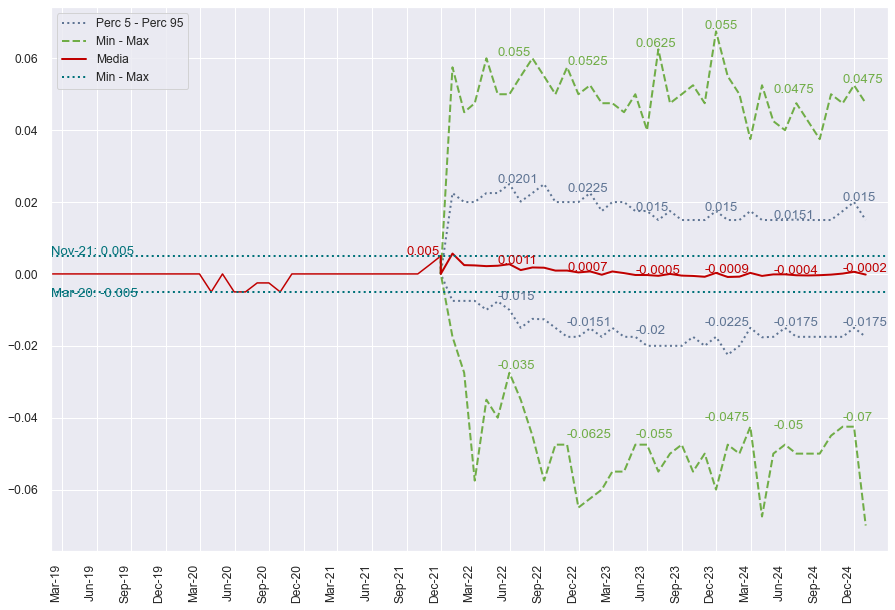

In [211]:
poisson.plot_full_variations('2019-01-01','2024-12-31', dec=4)

In [135]:
tibr_m

Fecha
2008-01-31    0.0950
2008-02-29    0.0975
2008-03-31    0.0975
2008-04-30    0.0975
2008-05-31    0.0975
               ...  
2021-06-30    0.0175
2021-07-31    0.0175
2021-08-31    0.0175
2021-09-30    0.0175
2021-10-31    0.0200
Freq: M, Name: TIBR, Length: 166, dtype: float64

<AxesSubplot:xlabel='Fecha'>

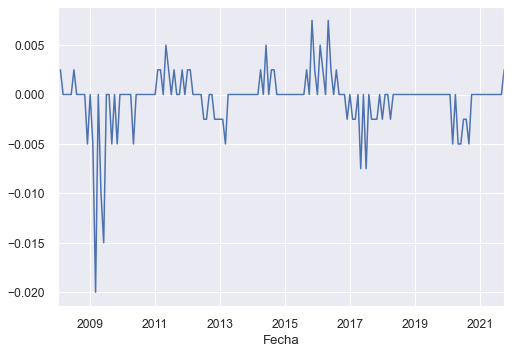

In [136]:
(tibr_m-tibr_m.shift(1)).plot()

In [196]:
row_index

array([[ 5,  0,  1, ...,  3,  0,  1],
       [ 7,  2,  1, ..., 13,  5,  3],
       [ 7,  6,  2, ..., 16,  6,  6],
       ...,
       [57, 59, 58, ..., 57, 58, 58],
       [57, 59, 58, ..., 57, 58, 58],
       [57, 59, 58, ..., 57, 58, 58]])

In [35]:
row_index = (0-np.log(np.random.uniform(size=(60,1000)))/0.41).round(0).cumsum(axis=0)
row_index = np.where(row_index>=60, np.NaN,row_index)
test_df = pd.DataFrame(row_index)
row_index = test_df.fillna(method='ffill').values.astype(int)
final = np.zeros((60,1000))

for i in range(1000):
    final[:,i] = result[row_index[:,i],i]
final = (final*400).round(0)/400

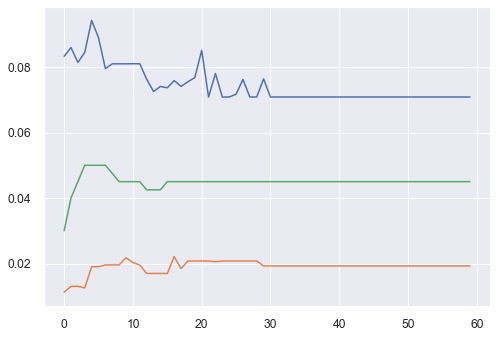

In [210]:
plt.plot(range(60),final.max(axis=1))
plt.plot(range(60),final.min(axis=1))
plt.plot(range(60),(final.mean(axis=1)*400).round(0)/400)

In [50]:
test[1,[3,6,3,32]]

array([-0.07989478,  0.08855019, -0.07989478,  0.00547739])

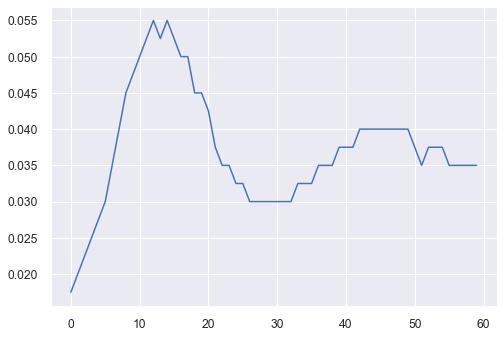

In [51]:
test = ((model_fit.forecast(60)).reshape(60,1)+np.random.normal(
    loc = 0,
    scale = model_fit.resid.std(),size=(60, 1000)))
test = (0.15/(1+np.exp(-test)))
plt.plot(range(60),(400*test.min(axis=1)).round(0)/400)

In [52]:
test[[3,5,2],[45,52, 16]]

array([0.03251531, 0.03687043, 0.02654595])

In [53]:
(np.random.uniform(0,5,size=100)*4).round(0)/4

array([2.75, 4.  , 3.  , 4.75, 4.5 , 4.5 , 1.75, 1.  , 0.25, 1.75, 1.75,
       3.  , 2.5 , 2.  , 1.75, 1.5 , 2.  , 1.75, 4.  , 4.25, 3.75, 4.  ,
       4.75, 1.  , 3.  , 2.5 , 3.75, 1.25, 0.  , 0.5 , 1.5 , 0.5 , 2.75,
       0.75, 2.75, 4.25, 4.5 , 3.  , 4.25, 2.  , 5.  , 0.75, 4.5 , 2.75,
       0.25, 0.25, 3.  , 3.25, 3.75, 3.  , 4.75, 3.75, 1.5 , 4.  , 5.  ,
       3.75, 3.  , 2.5 , 2.25, 2.  , 0.5 , 0.  , 3.25, 0.5 , 4.  , 4.25,
       1.  , 4.5 , 3.25, 4.75, 3.75, 4.75, 4.25, 3.25, 3.  , 2.25, 4.25,
       4.75, 1.5 , 1.25, 1.  , 4.5 , 5.  , 1.75, 5.  , 2.25, 5.  , 0.75,
       2.  , 3.5 , 4.5 , 3.25, 0.  , 2.25, 1.  , 4.  , 4.25, 2.5 , 0.  ,
       4.25])

In [47]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'eviews_tibr_forecast.xlsx',
 'historico_tasas_python.csv',
 'README.md',
 'Stochastic Rates Modeling.ipynb',
 'stochastic_modeling.py',
 '__pycache__']

In [19]:
1350000*53.13

71725500.0

In [75]:
t/(0.15-t)

-1.6

In [93]:
0.15/t

0.37499999999999994

In [94]:
t = .04
-np.log(0.15/t-1)#, np.log(t/(0.15-t))

-1.0116009116784799

In [144]:
trm = monthly_rates['TRM']
trm_gbm = stc.GBMRateSeries(trm,Np=10000, Nt=60, T=60, u_bound=9000)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

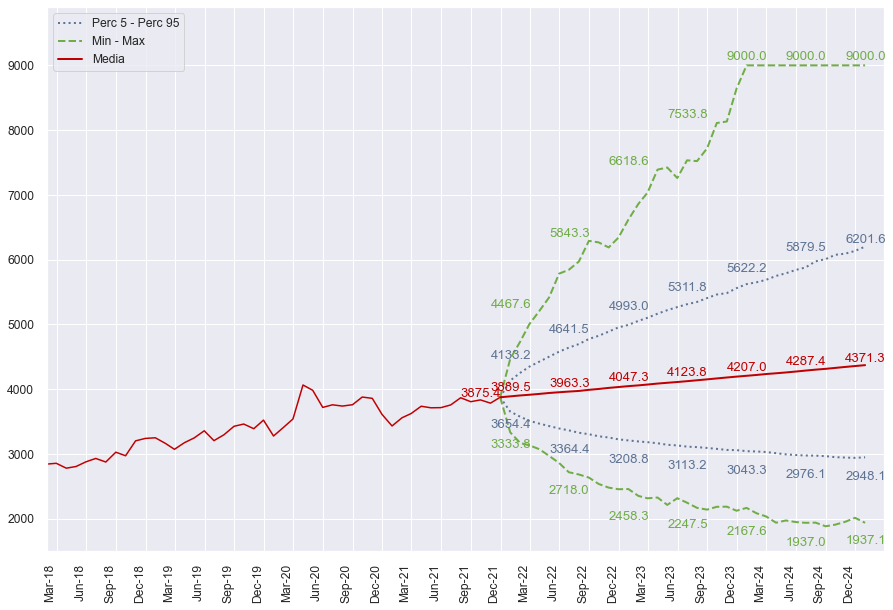

In [145]:
trm_gbm.plot_full_series('2018-01-01','2024-12-31')

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

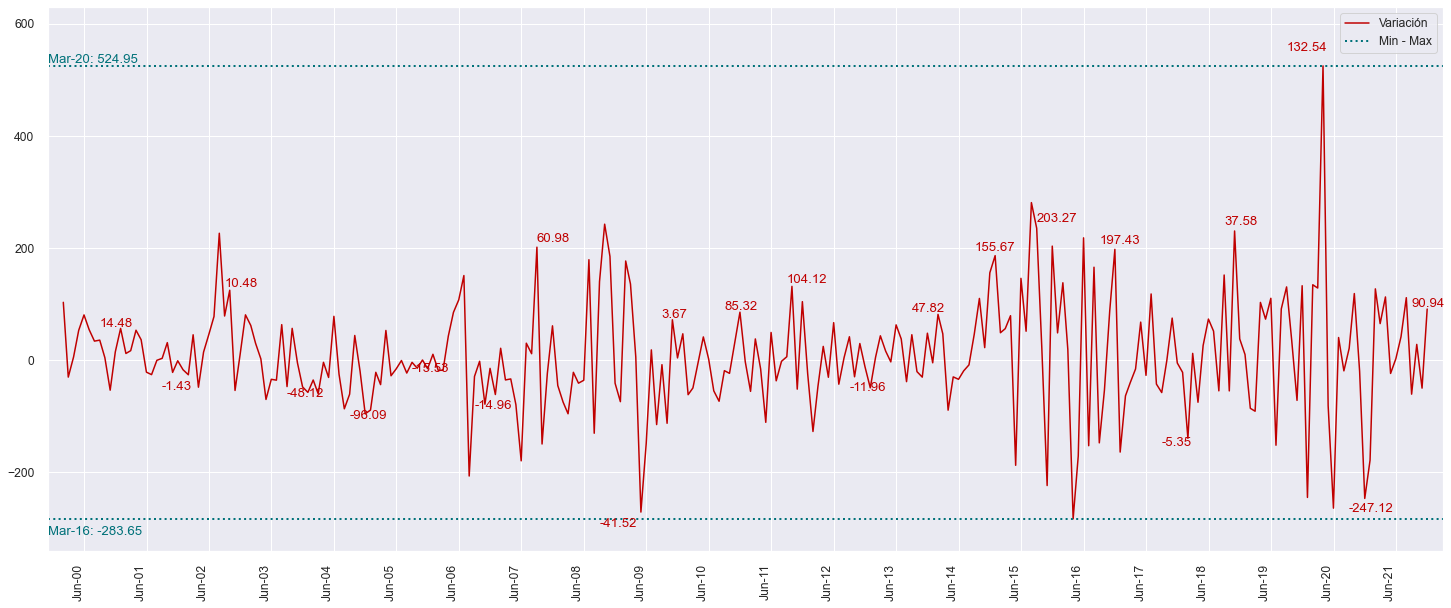

In [146]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10))

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

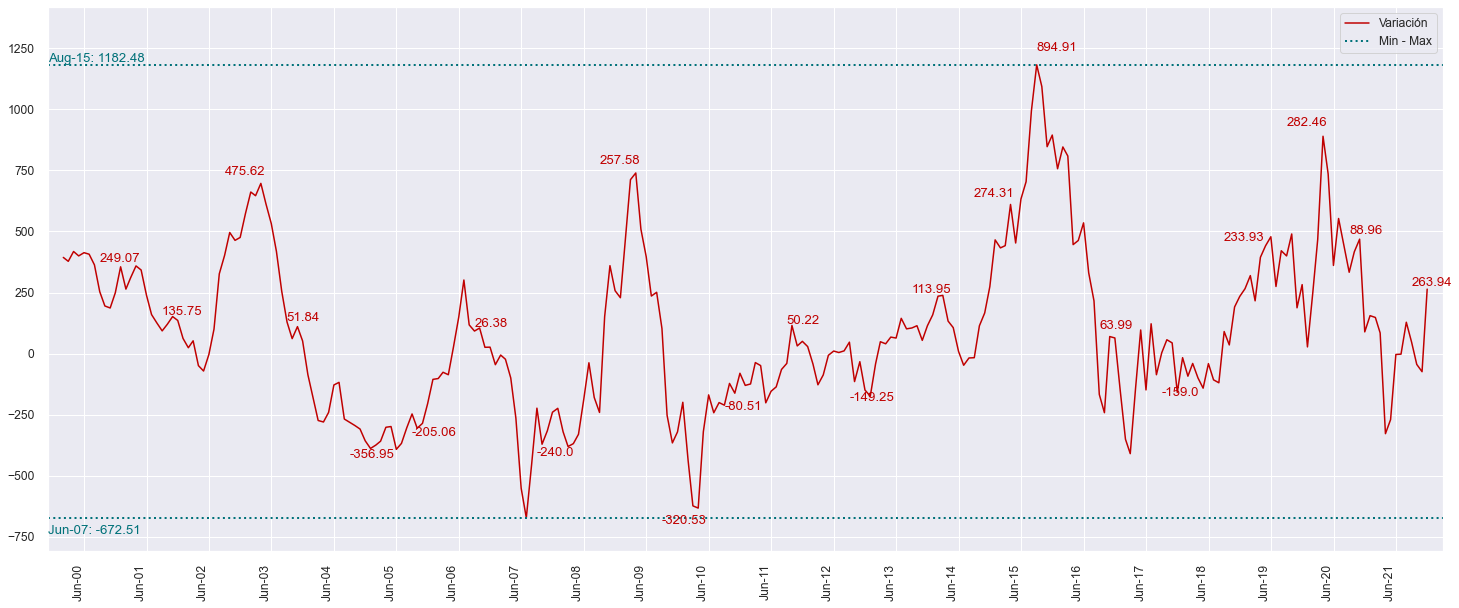

In [147]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10), ref=12)

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

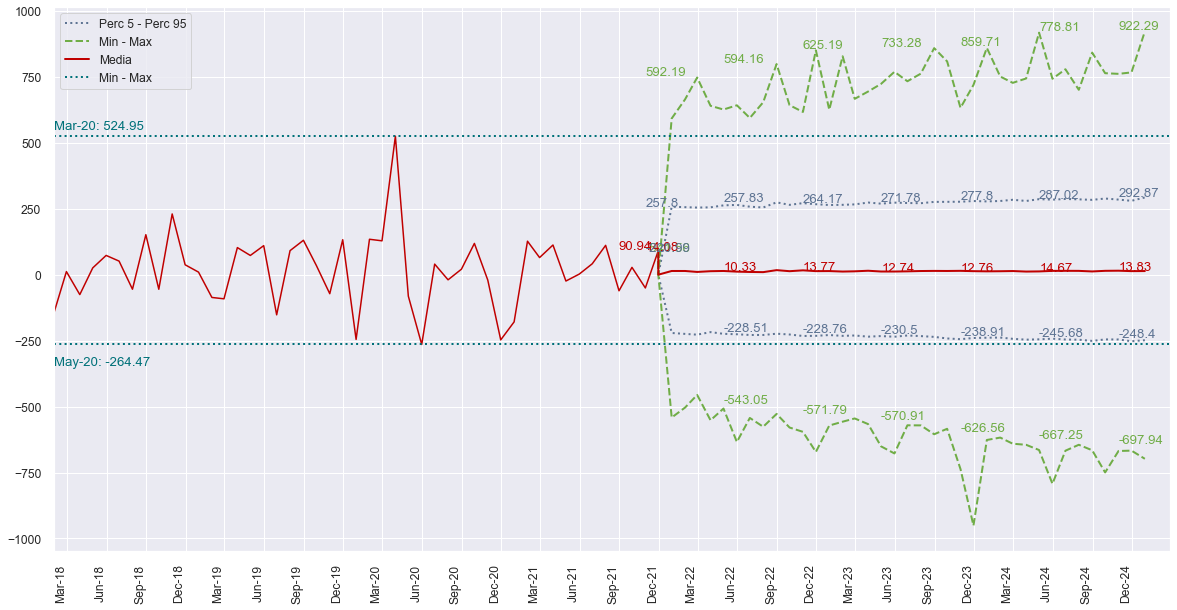

In [148]:
trm_gbm.plot_full_variations('2018-01-01', '2024-12-31', figsize=(20,10), dec=2)

In [152]:
(datetime.datetime.strptime('2021-01-01', '%Y-%m-%d')- datetime.datetime.strptime('2021-02-04', '%Y-%m-%d')).days

-34

In [101]:
np.log(trm/trm.shift(1)).agg(['min','mean','max', np.std])

min    -0.112046
mean    0.003253
max     0.138280
std     0.037212
Name: TRM, dtype: float64

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

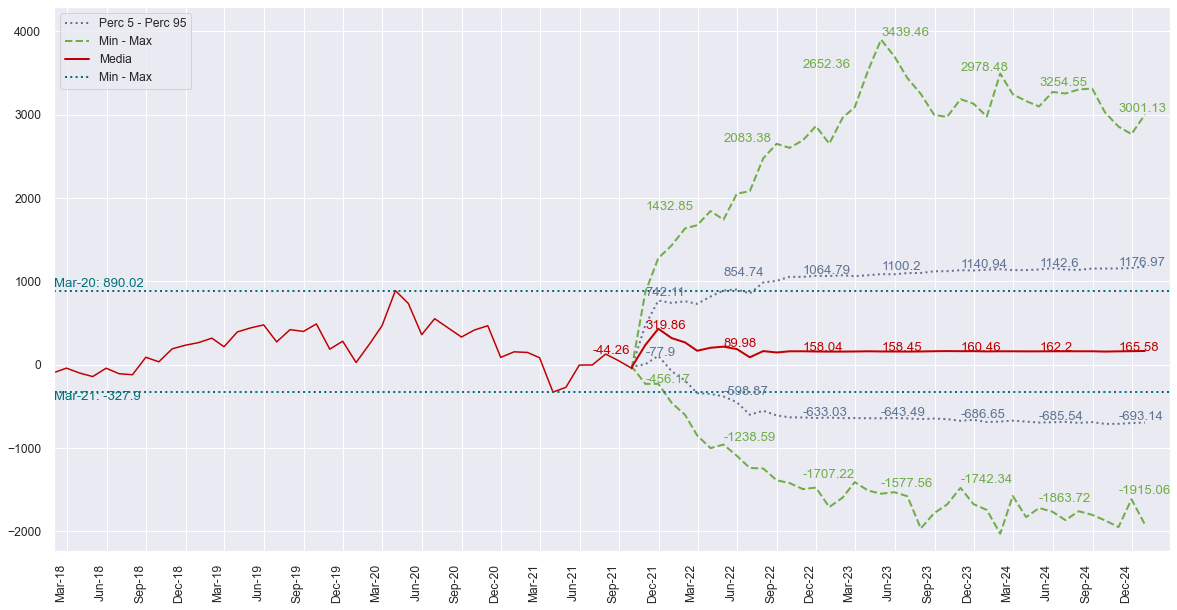

In [102]:
trm_gbm.plot_full_variations('2018-01-01', '2024-12-31', figsize=(20,10), ref=12, dec=2)

In [84]:
np.log(trm/trm.shift(1)).agg(['min','max','mean', 'std'])

min    -0.112046
max     0.138280
mean    0.003253
std     0.037212
Name: TRM, dtype: float64

<AxesSubplot:>

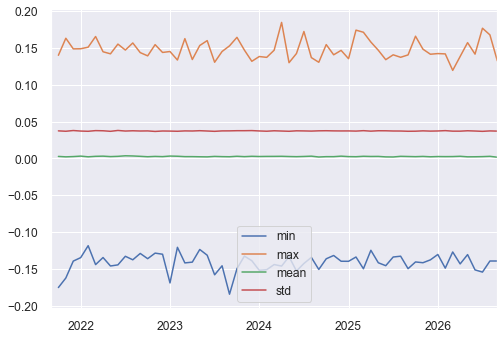

In [85]:
np.log(trm_gbm.sim_df/trm_gbm.sim_df.shift(1)).agg(['min','max','mean', 'std'], axis=1).plot()

In [29]:
trm_gbm.sim_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-09-30,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,...,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000
2021-10-31,3940.241312,4069.381346,4050.744576,3939.770528,3884.992783,3922.566265,4074.092099,3797.667502,3690.605862,3945.590183,...,4081.431614,4076.453331,3662.485604,3767.312146,3655.993802,3643.874234,3852.540147,3926.316059,3798.255342,3503.276802
2021-11-30,4060.906772,4089.467601,3990.520387,4023.919336,4063.333711,3791.887564,4282.509623,3864.659388,3639.010974,3841.209825,...,4129.805158,3684.727352,3616.743394,3962.418477,3595.223271,3516.173184,4141.682933,3977.489818,3655.192443,3356.545723
2021-12-31,4119.404120,4197.452498,4036.856334,4435.534673,4062.934826,4032.896183,4658.479319,3883.095769,3689.358910,3906.391975,...,4289.643444,3863.267961,3506.544791,3870.292763,3666.967157,3536.534898,4176.740849,3902.446840,3601.992100,3415.197865
2022-01-31,4319.663714,4233.638053,3997.748096,4277.810937,3991.751754,3897.599947,4888.489450,3787.250897,3839.789605,3911.010273,...,4091.604533,4046.768689,3472.424477,3792.240536,3730.751701,3512.575984,4088.297827,3903.292484,3356.926181,3288.904195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-05-31,4304.488250,7160.871212,4973.192113,7425.892950,3746.632631,6567.132179,5409.269880,3458.291134,6361.352911,3388.971761,...,5619.933470,5053.036726,4715.661258,3580.794113,5157.605966,4606.155815,4503.768542,4017.757399,2653.594811,4998.945558
2026-06-30,4623.074875,7283.787118,4772.209004,7354.357415,3654.892807,6562.986786,5326.037923,3424.596300,6946.532695,3538.176100,...,5574.645181,5298.686087,4990.384120,3755.682969,5030.601331,4761.011172,4485.215075,4178.041410,2860.170378,5067.988079
2026-07-31,4859.641580,7230.359823,4853.827854,7290.345204,3849.874638,6930.527156,5047.914873,3403.311501,6981.579608,3630.619456,...,5505.406881,5090.132993,4755.305915,3905.733322,5225.921505,4622.339981,4454.215958,4272.878522,2871.897988,5136.347241
2026-08-31,4789.665389,7518.462457,4857.375215,7744.461104,3969.403232,6976.767490,4811.352822,3577.107680,7008.167987,3581.501467,...,5559.800051,4856.721459,4781.456867,3881.135071,5266.409482,4506.979256,4452.413775,4418.893088,3002.477270,5392.070370


In [20]:
import datatable as dt

In [34]:
%%time
full_rates = pd.read_csv('historico_tasas_python.csv',index_col=0).astype(
    {'Fecha':'datetime64[ns]'}
).set_index('Fecha', drop=True)

Wall time: 110 ms


In [37]:
%%time 
full_rates = dt.fread('historico_tasas_python.csv').to_pandas().drop(
    columns = 'C0').set_index('Fecha', drop=True)


Wall time: 29.7 ms


In [42]:
def jump_class(x):
    if x>=5: return 5
    elif x==0: return 1
    else: return x
tibr = full_rates.loc['2000-01-01':,'TIBR']
saltos_tibr = tibr.loc[tibr/tibr.shift(1)!=1].to_frame().reset_index()
dc = saltos_tibr['Fecha']
shift_dc = dc.shift(1)
saltos_tibr['delta_t'] = 12*(dc.dt.year-shift_dc.dt.year)+dc.dt.month-\
    shift_dc.dt.month
saltos_tibr = saltos_tibr.loc[saltos_tibr['Fecha']>='2011-01-01']
saltos_tibr['clase'] = saltos_tibr['delta_t'].apply(jump_class)
lmbda = saltos_tibr['clase'].mean()

In [60]:
%%time 
for i in range(1000):
    temp_1 = saltos_tibr['delta_t'].apply(jump_class)


Wall time: 528 ms


In [59]:
%%time 
for i in range(1000):
    temp_2 = np.vectorize(jump_class)(saltos_tibr['delta_t'].values)

Wall time: 87.8 ms


In [58]:
515/81.6

6.311274509803922

In [63]:
temp_1.values==temp_2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])